We consider 2D Navier Stokes Equation under different noises: Deterministic, SALT, SFLT, Additive

\begin{align}
dq_t + J(\psi dt , q)= 0
\end{align}


\begin{align}
dq_t + J(\psi dt + \sum_{m=1}^M \xi_m\circ dW^m, q)= 0
\end{align}

\begin{align}
dq_t + J(\psi , q dt + \sum_{m=1}^M \xi_{m}\circ dW^m) = 0
\end{align}

\begin{align}
dq_t + J(\psi , q )dt + \sum_{m=1}^M \xi_{m} \circ dW^m= 0
\end{align}

The first case is deterministic, preserving casimirs and energy, up to solver tolerance. 
The second case is stochastic, preserves casimirs to solver tolerance. 
The third case is stochastic, preserves energy to solver tolerance, typically it is desirable to decay. 
The fourth case is stochastic and doesnt preserve any conservation laws.

In [1]:
import os
os.environ["JAX_ENABLE_X64"] = "true"
import sys
sys.path.append('..')
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.NS import *
from jax import config
jax.config.update("jax_enable_x64", True)
import numpy as np
from matplotlib.animation import FuncAnimation
from ml_collections import ConfigDict  # For parameters dictionary

In [2]:
params = ConfigDict(NS_params)
signal_model = NS_SETD_KT_CM_JAX(params) 
# Extract relevant parameters
xmin, xmax = signal_model.params["xmin"], signal_model.params["xmax"]
nx = signal_model.params["nt"]
S_1,S_2,S_3 = signal_model.params["S_1"], signal_model.params["S_2"], signal_model.params["S_3"]
E, tmax, dt, mu = signal_model.params["E"], signal_model.params["tmax"], signal_model.params["dt"], signal_model.params["mu"]
L,Nt,dx = signal_model.params["L"], signal_model.params["Nt"], signal_model.params["dx"]
# Spatial grids and spectral operators
x = signal_model.x
xx, yy = signal_model.xx, signal_model.yy
kx, ky = signal_model.kx, signal_model.ky
ksq = signal_model.ksq
Lhat = signal_model.Lhat
# Basis and forcing
E_1,E_2,Q = signal_model.E_1, signal_model.E_2, signal_model.Q
f1,f2,f3 = signal_model.f1, signal_model.f2, signal_model.f3
basis_1 = signal_model.basis_1
basis_2 = signal_model.basis_2
basis_3 = signal_model.basis_3
# Initial condition
q_ic = initial_condition(xx, yy, E, name=params['initial_condition'])
# %% Plot basis functions
output = signal_model.run_2(initial_state=signal_model.psi0,
                            n_steps=signal_model.params['Nt'],
                            noise=None,
                            key=jax.random.PRNGKey(0),
                            save_every=16)


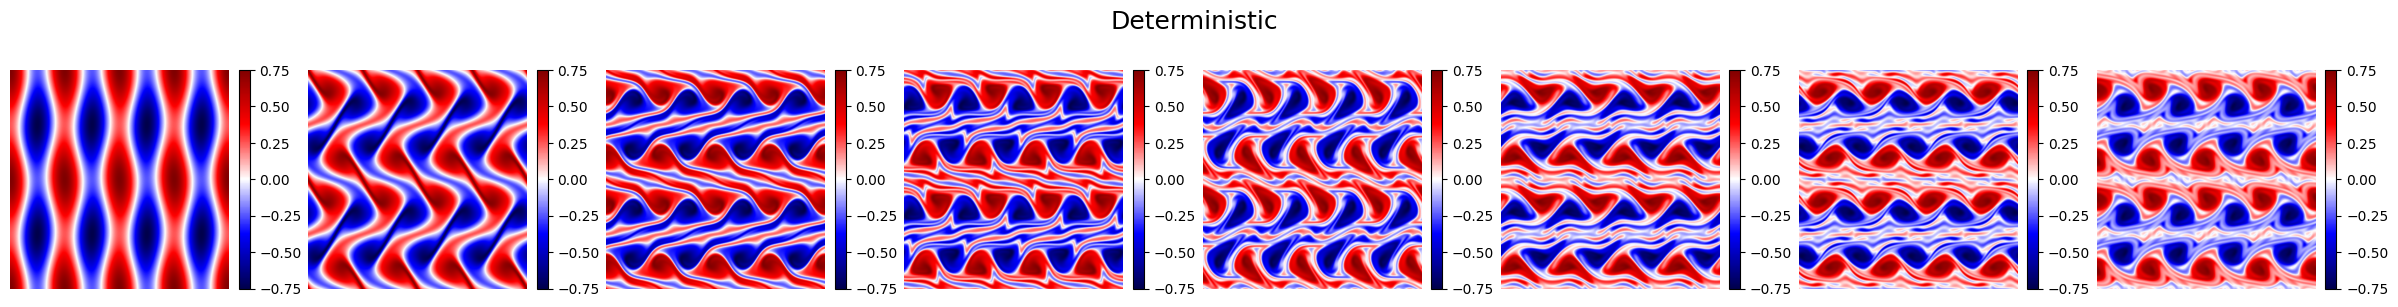

In [ ]:
num_snapshots = 8
snapshot_indices = np.linspace(0, Nt/16 - 1, num_snapshots, dtype=int)
fig, axs = plt.subplots(1, num_snapshots, figsize=(3*num_snapshots, 3))
vmin = jnp.real(output[1][:, 0]).min()
vmax = jnp.real(output[1][:, 0]).max()
for i, idx in enumerate(snapshot_indices):
    ax = axs[i]
    im = ax.imshow(jnp.real(output[1][idx, 0]), extent=[xmin, xmax, xmin, xmax], origin="lower",
                   cmap="seismic", aspect='equal', vmin=vmin, vmax=vmax)
    ax.set_title(f"T {i*80/num_snapshots}", fontsize=10)
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.suptitle("Deterministic", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/NS/Det.png', dpi=300)

plt.show()

<>:40: SyntaxWarning: invalid escape sequence '\i'
<>:45: SyntaxWarning: invalid escape sequence '\i'
<>:40: SyntaxWarning: invalid escape sequence '\i'
<>:45: SyntaxWarning: invalid escape sequence '\i'
/var/folders/b8/9fr86yj96kd4pyp7zgrz4f6h0000gn/T/ipykernel_46259/2344246974.py:40: SyntaxWarning: invalid escape sequence '\i'
  plt.title("Casimir 1 ($\int q$)")
/var/folders/b8/9fr86yj96kd4pyp7zgrz4f6h0000gn/T/ipykernel_46259/2344246974.py:45: SyntaxWarning: invalid escape sequence '\i'
  plt.title("Casimir 2 ($\int q^2$)")


(500, 512, 512)


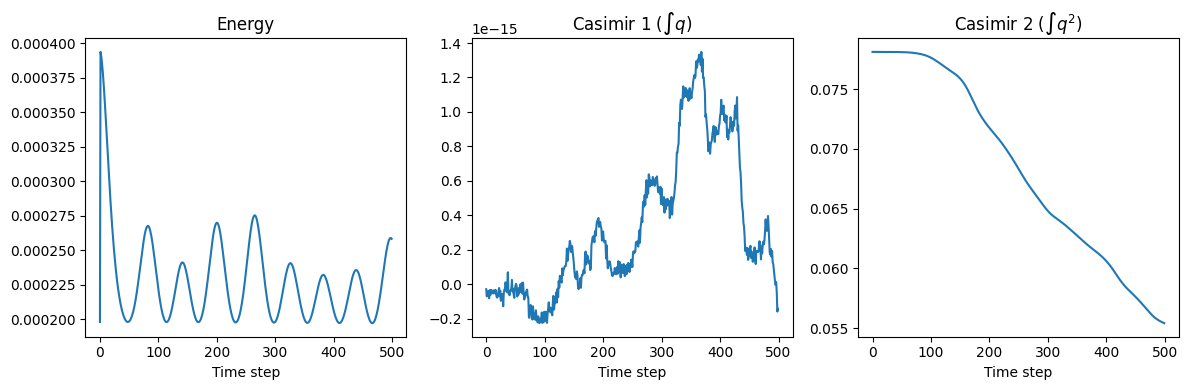

In [4]:
# Compute energy and first two Casimirs for all times
q = output[1][:, 0]    # shape: (Nt, nx, nx)
print(q.shape)
# Compute psi from q using spectral inversion: psi_hat = -q_hat / ksq (with ksq[0,0] handled)
q_hat = jnp.fft.fft2(q)
ksq_safe = ksq.copy()
ksq_safe = ksq_safe.at[0, 0].set(1.0)  # avoid division by zero
psi_hat = -q_hat / ksq_safe
psi_hat = psi_hat.at[0, 0].set(0.0)    # set mean to zero
psi = jnp.fft.ifft2(psi_hat).real

energy = []
casimir1 = []
casimir2 = []

for t in range(q.shape[0]):
    q_t = q[t]
    psi_t = psi[t]
    energy.append(-jnp.sum(q_t * psi_t) * dx * dx)
    casimir1.append(jnp.sum(q_t) * dx * dx)
    casimir2.append(1/2*jnp.sum(q_t**2) * dx * dx)

energy = np.array(energy)
casimir1 = np.array(casimir1)
casimir2 = np.array(casimir2)

# Make energy relative to the initial energy
# energy = energy / energy[0]
# casimir1 = casimir1 / casimir1[0]
# casimir2 = casimir2 / casimir2[0]

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(energy)
plt.title("Energy")
plt.xlabel("Time step")

plt.subplot(1, 3, 2)
plt.plot(casimir1)
plt.title("Casimir 1 ($\int q$)")
plt.xlabel("Time step")

plt.subplot(1, 3, 3)
plt.plot(casimir2)
plt.title("Casimir 2 ($\int q^2$)")
plt.xlabel("Time step")

plt.tight_layout()
plt.show()

energy_det = energy 
casimir1_det = casimir1
casimir2_det = casimir2

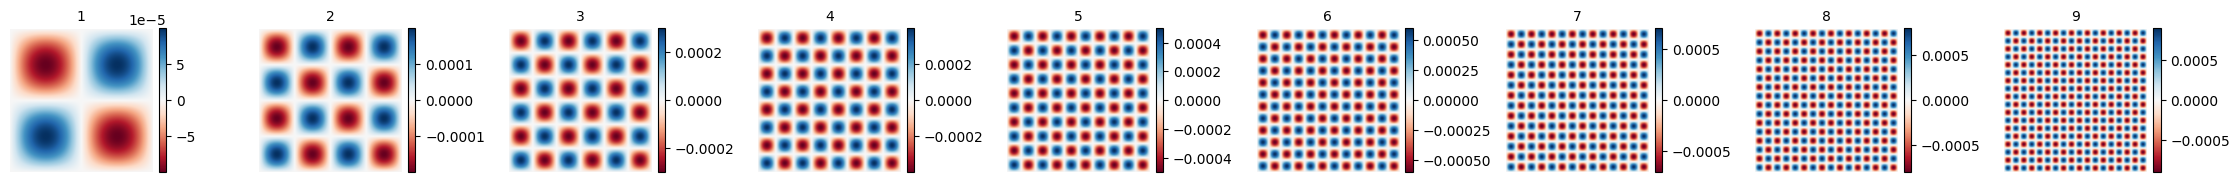

In [5]:
params = ConfigDict(NS_params_salt)
signal_model = NS_SETD_KT_CM_JAX(params) 
# Extract relevant parameters
xmin, xmax = signal_model.params["xmin"], signal_model.params["xmax"]
nx = signal_model.params["nt"]
S_1,S_2,S_3 = signal_model.params["S_1"], signal_model.params["S_2"], signal_model.params["S_3"]
E, tmax, dt, mu = signal_model.params["E"], signal_model.params["tmax"], signal_model.params["dt"], signal_model.params["mu"]
L,Nt,dx = signal_model.params["L"], signal_model.params["Nt"], signal_model.params["dx"]
# Spatial grids and spectral operators
x = signal_model.x
xx, yy = signal_model.xx, signal_model.yy
kx, ky = signal_model.kx, signal_model.ky
ksq = signal_model.ksq
Lhat = signal_model.Lhat
# Basis and forcing
E_1,E_2,Q = signal_model.E_1, signal_model.E_2, signal_model.Q
f1,f2,f3 = signal_model.f1, signal_model.f2, signal_model.f3
basis_1 = signal_model.basis_1
basis_2 = signal_model.basis_2
basis_3 = signal_model.basis_3
# Initial condition
q_ic = initial_condition(xx, yy, E, name=params['initial_condition'])
# %% Plot basis functions
num_to_plot = min(9, basis_1.shape[0])
fig, axs = plt.subplots(1, num_to_plot, figsize=(2.5*num_to_plot, 3))
for i in range(num_to_plot):
    ax = axs[i]
    im = ax.imshow(basis_1[i], extent=[xmin, xmax, xmin, xmax], origin="lower", cmap="RdBu", aspect='equal')
    ax.set_title(f"{i+1}", fontsize=10)
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()
# %% Generate random noise and run simulation
dWs = np.random.randn(Nt, basis_1.shape[0]) * jnp.sqrt(dt)/dt

output = signal_model.run_2(initial_state=signal_model.psi0,
                            n_steps=signal_model.params['Nt'],
                            noise=None,
                            key=jax.random.PRNGKey(0),
                            save_every=16)


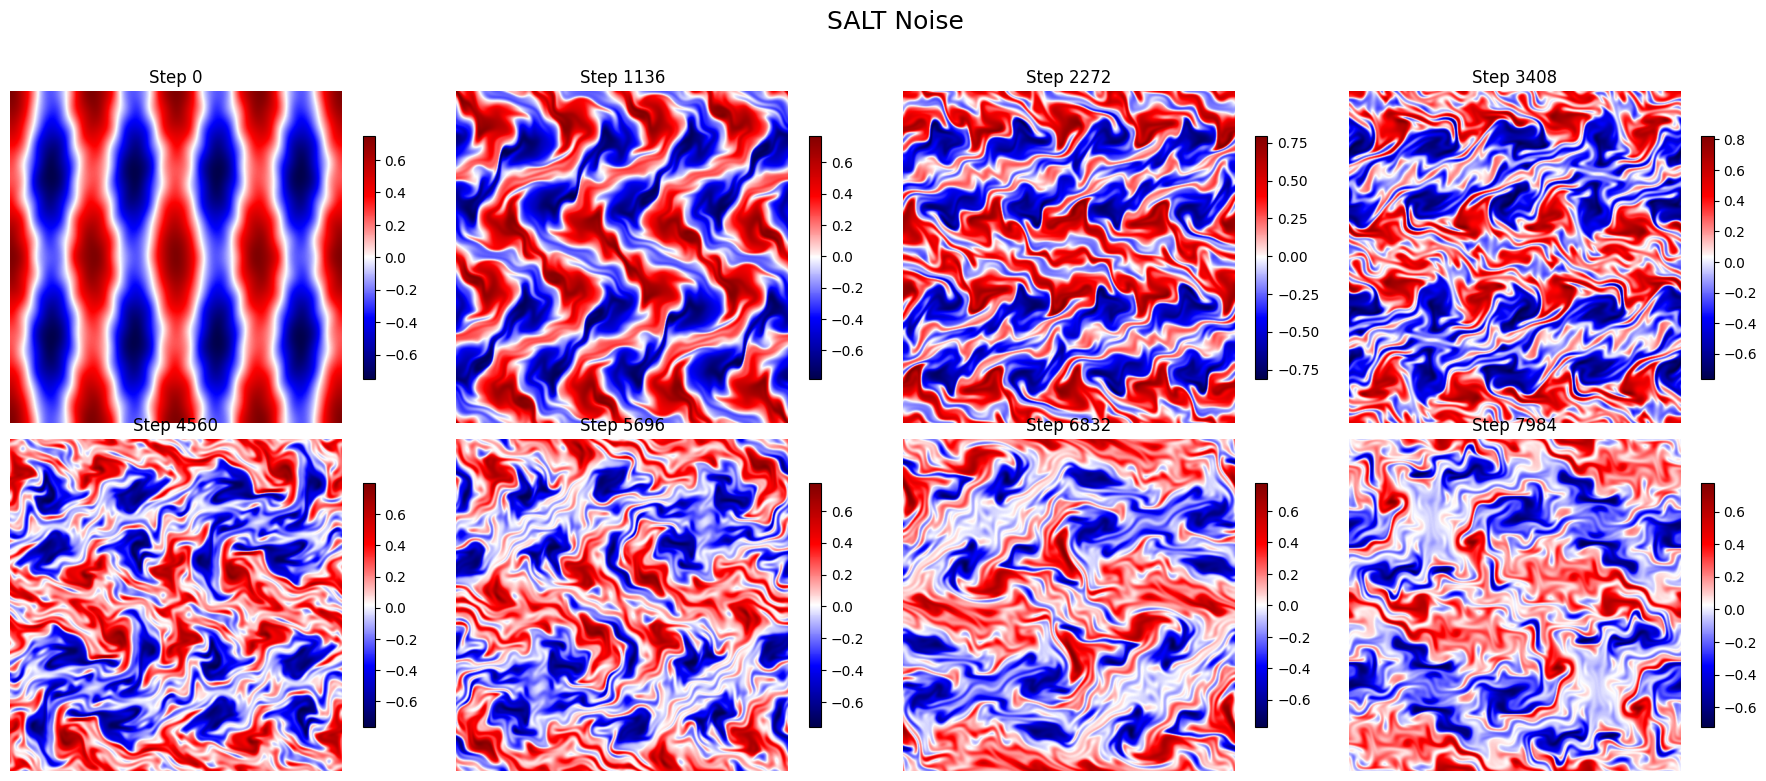

In [6]:
num_snapshots = 8
snapshot_indices = np.linspace(0, Nt/16 - 1, num_snapshots, dtype=int)
fig, axs = plt.subplots(2, 4, figsize=(18, 8))
for i, idx in enumerate(snapshot_indices):
    ax = axs.flat[i]
    im = ax.imshow(jnp.real(output[1][idx, 0]), extent=[xmin, xmax, xmin, xmax], origin="lower", cmap="seismic", aspect='equal')
    ax.set_title(f"Step {idx*16}")
    ax.axis('off')
    fig.colorbar(im, ax=ax, shrink=0.7)
plt.suptitle("SALT Noise", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<>:38: SyntaxWarning: invalid escape sequence '\i'
<>:43: SyntaxWarning: invalid escape sequence '\i'
<>:38: SyntaxWarning: invalid escape sequence '\i'
<>:43: SyntaxWarning: invalid escape sequence '\i'
/var/folders/b8/9fr86yj96kd4pyp7zgrz4f6h0000gn/T/ipykernel_46259/3077061241.py:38: SyntaxWarning: invalid escape sequence '\i'
  plt.title("Casimir 1 ($\int q$)")
/var/folders/b8/9fr86yj96kd4pyp7zgrz4f6h0000gn/T/ipykernel_46259/3077061241.py:43: SyntaxWarning: invalid escape sequence '\i'
  plt.title("Casimir 2 ($\int q^2$)")


(500, 512, 512)


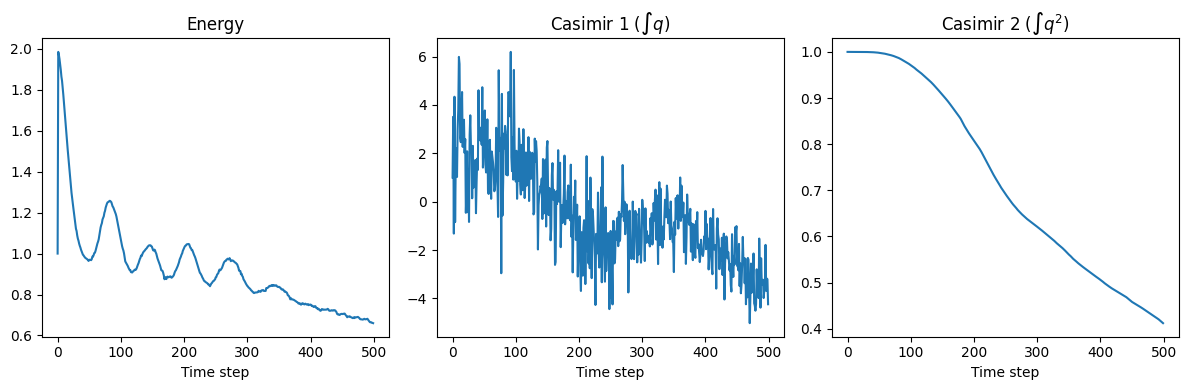

In [7]:
# Compute energy and first two Casimirs for all times
q = output[1][:, 0]    # shape: (Nt, nx, nx)
print(q.shape)
# Compute psi from q using spectral inversion: psi_hat = -q_hat / ksq (with ksq[0,0] handled)
q_hat = jnp.fft.fft2(q)
ksq_safe = ksq.copy()
ksq_safe = ksq_safe.at[0, 0].set(1.0)  # avoid division by zero
psi_hat = -q_hat / ksq_safe
psi_hat = psi_hat.at[0, 0].set(0.0)    # set mean to zero
psi = jnp.fft.ifft2(psi_hat).real

energy = []
casimir1 = []
casimir2 = []

for t in range(q.shape[0]):
    q_t = q[t]
    psi_t = psi[t]
    energy.append(-jnp.sum(q_t * psi_t) * dx * dx)
    casimir1.append(jnp.sum(q_t) * dx * dx)
    casimir2.append(1/2*jnp.sum(q_t**2) * dx * dx)

energy = np.array(energy)
casimir1 = np.array(casimir1)
casimir2 = np.array(casimir2)
energy = energy / energy[0]
casimir1 = casimir1 / casimir1[0]
casimir2 = casimir2 / casimir2[0]

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(energy)
plt.title("Energy")
plt.xlabel("Time step")

plt.subplot(1, 3, 2)
plt.plot(casimir1)
plt.title("Casimir 1 ($\int q$)")
plt.xlabel("Time step")

plt.subplot(1, 3, 3)
plt.plot(casimir2)
plt.title("Casimir 2 ($\int q^2$)")
plt.xlabel("Time step")

plt.tight_layout()
plt.show()

energy_salt = energy 
casimir1_salt = casimir1
casimir2_salt = casimir2

In [8]:
del params, signal_model

params = ConfigDict(NS_params_sflt)
signal_model = NS_SETD_KT_CM_JAX(params) 
# Extract relevant parameters
xmin, xmax = signal_model.params["xmin"], signal_model.params["xmax"]
nx = signal_model.params["nt"]
S_1,S_2,S_3 = signal_model.params["S_1"], signal_model.params["S_2"], signal_model.params["S_3"]
E, tmax, dt, mu = signal_model.params["E"], signal_model.params["tmax"], signal_model.params["dt"], signal_model.params["mu"]
L,Nt,dx = signal_model.params["L"], signal_model.params["Nt"], signal_model.params["dx"]
# Spatial grids and spectral operators
x = signal_model.x
xx, yy = signal_model.xx, signal_model.yy
kx, ky = signal_model.kx, signal_model.ky
ksq = signal_model.ksq
Lhat = signal_model.Lhat
# Basis and forcing
E_1,E_2,Q = signal_model.E_1, signal_model.E_2, signal_model.Q
f1,f2,f3 = signal_model.f1, signal_model.f2, signal_model.f3
basis_1 = signal_model.basis_1
basis_2 = signal_model.basis_2
basis_3 = signal_model.basis_3
# Initial condition
q_ic = initial_condition(xx, yy, E, name=params['initial_condition'])
# %% Plot basis functions

# %% Generate random noise and run simulation
dWs = np.random.randn(Nt, basis_1.shape[0]) * jnp.sqrt(dt)/dt

output = signal_model.run_2(initial_state=signal_model.psi0,
                            n_steps=signal_model.params['Nt'],
                            noise=None,
                            key=jax.random.PRNGKey(0),
                            save_every=16)


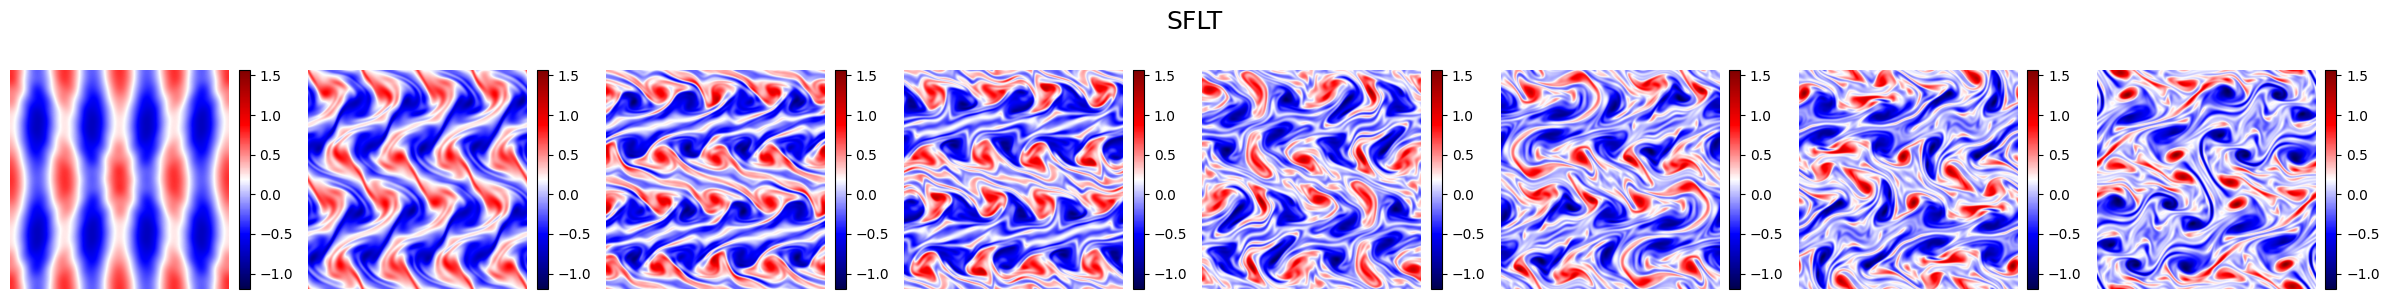

In [9]:

num_snapshots = 8
snapshot_indices = np.linspace(0, Nt/16 - 1, num_snapshots, dtype=int)
fig, axs = plt.subplots(1, num_snapshots, figsize=(3*num_snapshots, 3))
vmin = jnp.real(output[1][:, 0]).min()
vmax = jnp.real(output[1][:, 0]).max()
for i, idx in enumerate(snapshot_indices):
    ax = axs[i]
    im = ax.imshow(jnp.real(output[1][idx, 0]), extent=[xmin, xmax, xmin, xmax], origin="lower",
                   cmap="seismic", aspect='equal', vmin=vmin, vmax=vmax)
    #ax.set_title(f"Step {idx*16}", fontsize=10)
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.suptitle("SFLT", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/NS/SFLT.png', dpi=300)
plt.show()



<>:35: SyntaxWarning: invalid escape sequence '\i'
<>:40: SyntaxWarning: invalid escape sequence '\i'
<>:35: SyntaxWarning: invalid escape sequence '\i'
<>:40: SyntaxWarning: invalid escape sequence '\i'
/var/folders/b8/9fr86yj96kd4pyp7zgrz4f6h0000gn/T/ipykernel_46259/955830064.py:35: SyntaxWarning: invalid escape sequence '\i'
  plt.title("Casimir 1 ($\int q$)")
/var/folders/b8/9fr86yj96kd4pyp7zgrz4f6h0000gn/T/ipykernel_46259/955830064.py:40: SyntaxWarning: invalid escape sequence '\i'
  plt.title("Casimir 2 ($\int q^2$)")


(500, 512, 512)


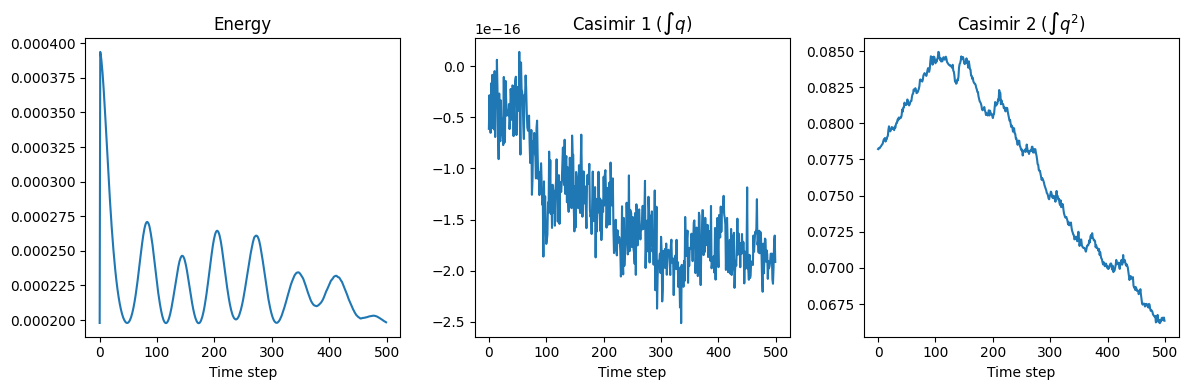

In [10]:
# Compute energy and first two Casimirs for all times
q = output[1][:, 0]    # shape: (Nt, nx, nx)
print(q.shape)
# Compute psi from q using spectral inversion: psi_hat = -q_hat / ksq (with ksq[0,0] handled)
q_hat = jnp.fft.fft2(q)
ksq_safe = ksq.copy()
ksq_safe = ksq_safe.at[0, 0].set(1.0)  # avoid division by zero
psi_hat = -q_hat / ksq_safe
psi_hat = psi_hat.at[0, 0].set(0.0)    # set mean to zero
psi = jnp.fft.ifft2(psi_hat).real

energy = []
casimir1 = []
casimir2 = []

for t in range(q.shape[0]):
    q_t = q[t]
    psi_t = psi[t]
    energy.append(-jnp.sum(q_t * psi_t) * dx * dx)
    casimir1.append(jnp.sum(q_t) * dx * dx)
    casimir2.append(1/2*jnp.sum(q_t**2) * dx * dx)

energy = np.array(energy)
casimir1 = np.array(casimir1)
casimir2 = np.array(casimir2)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(energy)
plt.title("Energy")
plt.xlabel("Time step")

plt.subplot(1, 3, 2)
plt.plot(casimir1)
plt.title("Casimir 1 ($\int q$)")
plt.xlabel("Time step")

plt.subplot(1, 3, 3)
plt.plot(casimir2)
plt.title("Casimir 2 ($\int q^2$)")
plt.xlabel("Time step")

plt.tight_layout()
plt.show()


energy_sflt = energy 
casimir1_sflt = casimir1
casimir2_sflt = casimir2

In [11]:
del params, signal_model
params = ConfigDict(NS_params_additive)
signal_model = NS_SETD_KT_CM_JAX(params) 
# Extract relevant parameters
xmin, xmax = signal_model.params["xmin"], signal_model.params["xmax"]
nx = signal_model.params["nt"]
S_1,S_2,S_3 = signal_model.params["S_1"], signal_model.params["S_2"], signal_model.params["S_3"]
E, tmax, dt, mu = signal_model.params["E"], signal_model.params["tmax"], signal_model.params["dt"], signal_model.params["mu"]
L,Nt,dx = signal_model.params["L"], signal_model.params["Nt"], signal_model.params["dx"]
# Spatial grids and spectral operators
x = signal_model.x
xx, yy = signal_model.xx, signal_model.yy
kx, ky = signal_model.kx, signal_model.ky
ksq = signal_model.ksq
Lhat = signal_model.Lhat
# Basis and forcing
E_1,E_2,Q = signal_model.E_1, signal_model.E_2, signal_model.Q
f1,f2,f3 = signal_model.f1, signal_model.f2, signal_model.f3
basis_1 = signal_model.basis_1
basis_2 = signal_model.basis_2
basis_3 = signal_model.basis_3
# Initial condition
q_ic = initial_condition(xx, yy, E, name=params['initial_condition'])
output = signal_model.run_2(initial_state=signal_model.psi0,
                            n_steps=signal_model.params['Nt'],
                            noise=None,
                            key=jax.random.PRNGKey(0),
                            save_every=16)


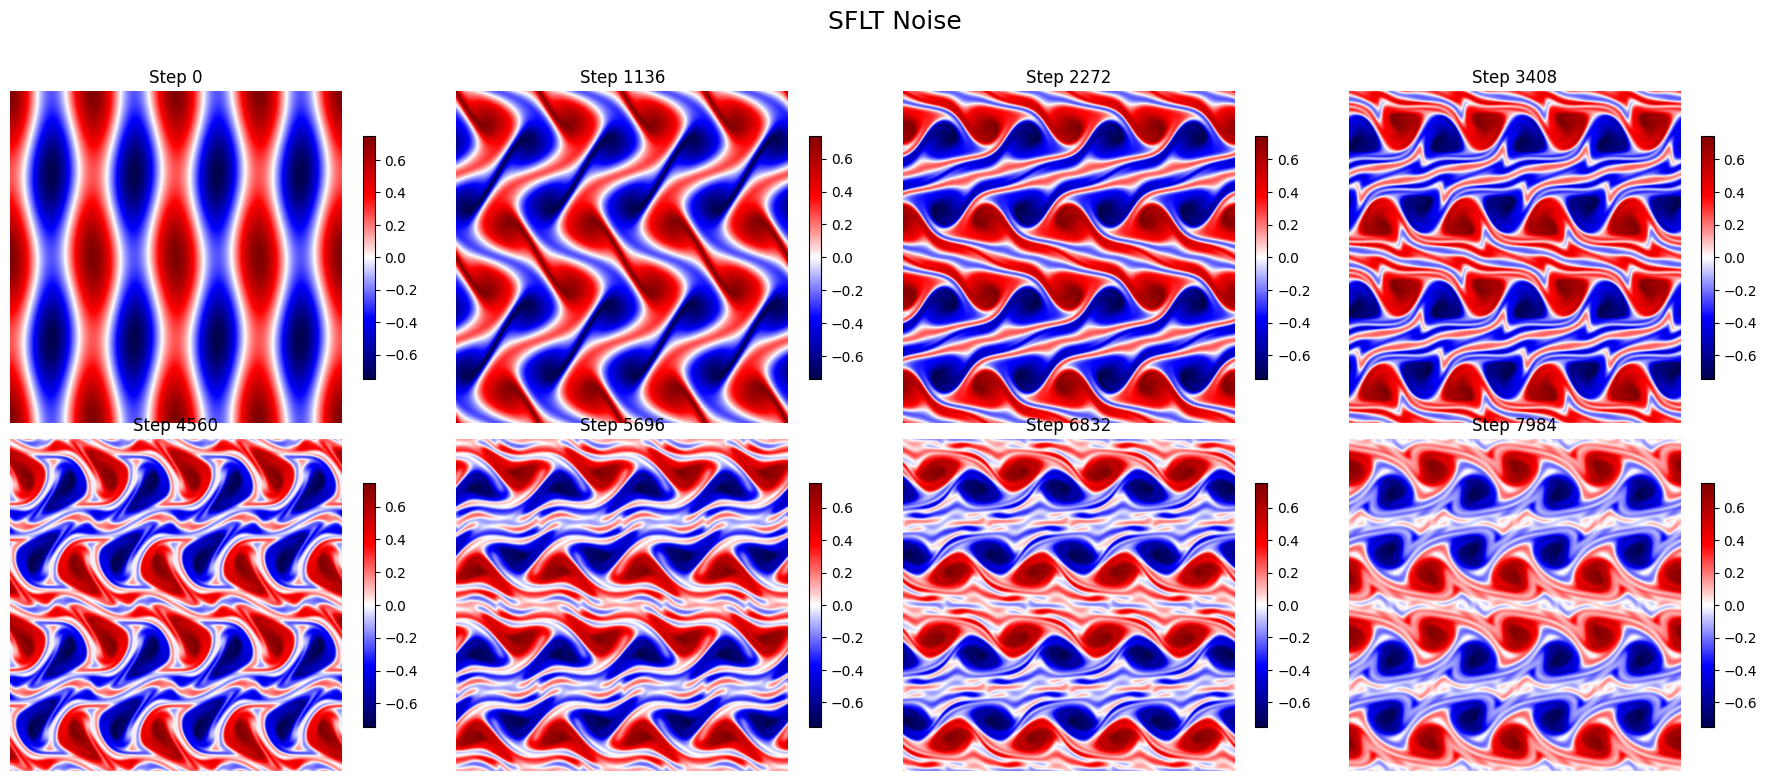

In [ ]:
num_snapshots = 8
snapshot_indices = np.linspace(0, Nt/16 - 1, num_snapshots, dtype=int)
fig, axs = plt.subplots(2, 4, figsize=(18, 8))
for i, idx in enumerate(snapshot_indices):
    ax = axs.flat[i]
    im = ax.imshow(jnp.real(output[1][idx, 0]), extent=[xmin, xmax, xmin, xmax], origin="lower", cmap="seismic", aspect='equal')
    ax.set_title(f"Step {idx*16}")
    ax.axis('off')
    fig.colorbar(im, ax=ax, shrink=0.7)
plt.suptitle("Additive Noise", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<>:35: SyntaxWarning: invalid escape sequence '\i'
<>:40: SyntaxWarning: invalid escape sequence '\i'
<>:35: SyntaxWarning: invalid escape sequence '\i'
<>:40: SyntaxWarning: invalid escape sequence '\i'
/var/folders/b8/9fr86yj96kd4pyp7zgrz4f6h0000gn/T/ipykernel_46259/1422573968.py:35: SyntaxWarning: invalid escape sequence '\i'
  plt.title("Casimir 1 ($\int q$)")
/var/folders/b8/9fr86yj96kd4pyp7zgrz4f6h0000gn/T/ipykernel_46259/1422573968.py:40: SyntaxWarning: invalid escape sequence '\i'
  plt.title("Casimir 2 ($\int q^2$)")


(500, 512, 512)


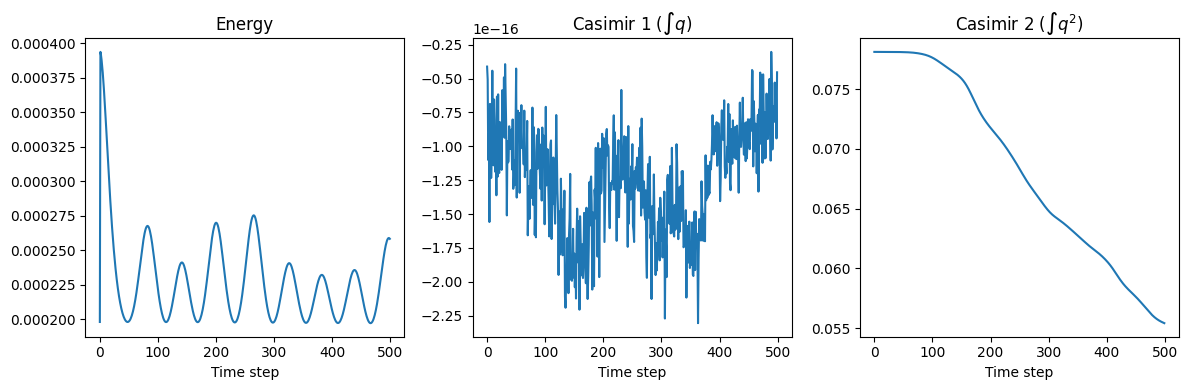

In [13]:
# Compute energy and first two Casimirs for all times
q = output[1][:, 0]    # shape: (Nt, nx, nx)
print(q.shape)
# Compute psi from q using spectral inversion: psi_hat = -q_hat / ksq (with ksq[0,0] handled)
q_hat = jnp.fft.fft2(q)
ksq_safe = ksq.copy()
ksq_safe = ksq_safe.at[0, 0].set(1.0)  # avoid division by zero
psi_hat = -q_hat / ksq_safe
psi_hat = psi_hat.at[0, 0].set(0.0)    # set mean to zero
psi = jnp.fft.ifft2(psi_hat).real

energy = []
casimir1 = []
casimir2 = []

for t in range(q.shape[0]):
    q_t = q[t]
    psi_t = psi[t]
    energy.append(-jnp.sum(q_t * psi_t) * dx * dx)
    casimir1.append(jnp.sum(q_t) * dx * dx)
    casimir2.append(1/2*jnp.sum(q_t**2) * dx * dx)

energy = np.array(energy)
casimir1 = np.array(casimir1)
casimir2 = np.array(casimir2)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(energy)
plt.title("Energy")
plt.xlabel("Time step")

plt.subplot(1, 3, 2)
plt.plot(casimir1)
plt.title("Casimir 1 ($\int q$)")
plt.xlabel("Time step")

plt.subplot(1, 3, 3)
plt.plot(casimir2)
plt.title("Casimir 2 ($\int q^2$)")
plt.xlabel("Time step")

plt.tight_layout()
plt.show()

energy_add = energy 
casimir1_add = casimir1
casimir2_add = casimir2

<>:7: SyntaxWarning: invalid escape sequence '\i'
<>:19: SyntaxWarning: invalid escape sequence '\i'
<>:32: SyntaxWarning: invalid escape sequence '\i'
<>:7: SyntaxWarning: invalid escape sequence '\i'
<>:19: SyntaxWarning: invalid escape sequence '\i'
<>:32: SyntaxWarning: invalid escape sequence '\i'
/var/folders/b8/9fr86yj96kd4pyp7zgrz4f6h0000gn/T/ipykernel_46259/88709887.py:7: SyntaxWarning: invalid escape sequence '\i'
  plt.ylabel('energy ($\int q$)')
/var/folders/b8/9fr86yj96kd4pyp7zgrz4f6h0000gn/T/ipykernel_46259/88709887.py:19: SyntaxWarning: invalid escape sequence '\i'
  plt.ylabel('Casimir 1 ($\int q$)')
/var/folders/b8/9fr86yj96kd4pyp7zgrz4f6h0000gn/T/ipykernel_46259/88709887.py:32: SyntaxWarning: invalid escape sequence '\i'
  plt.ylabel('Casimir 2 ($\int q^2$)')


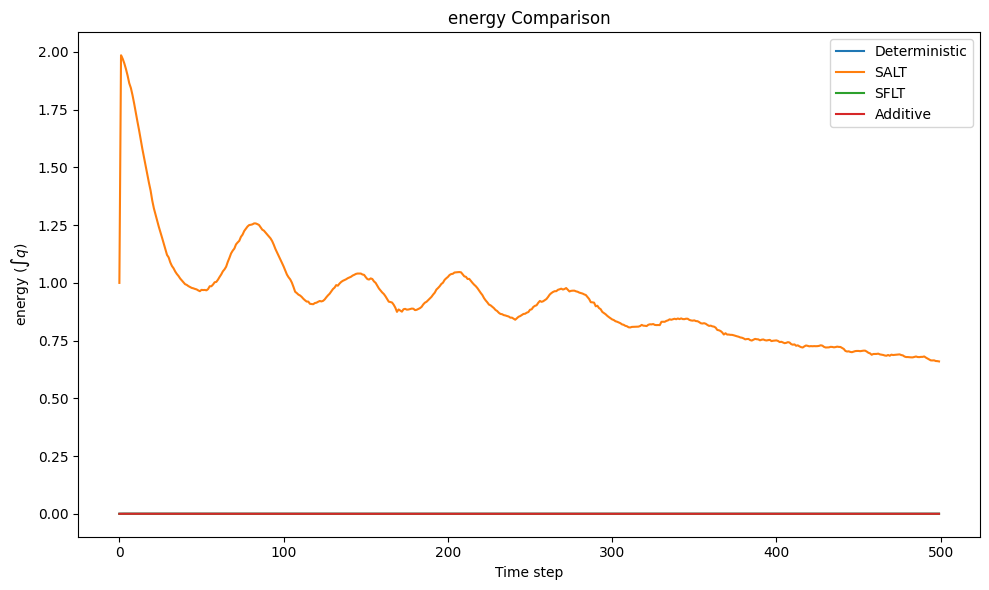

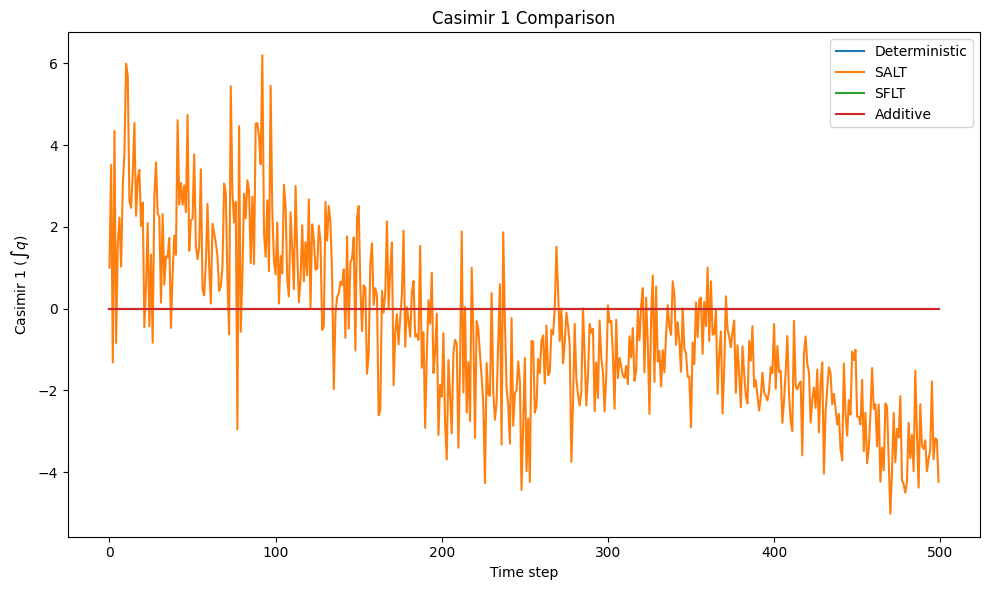

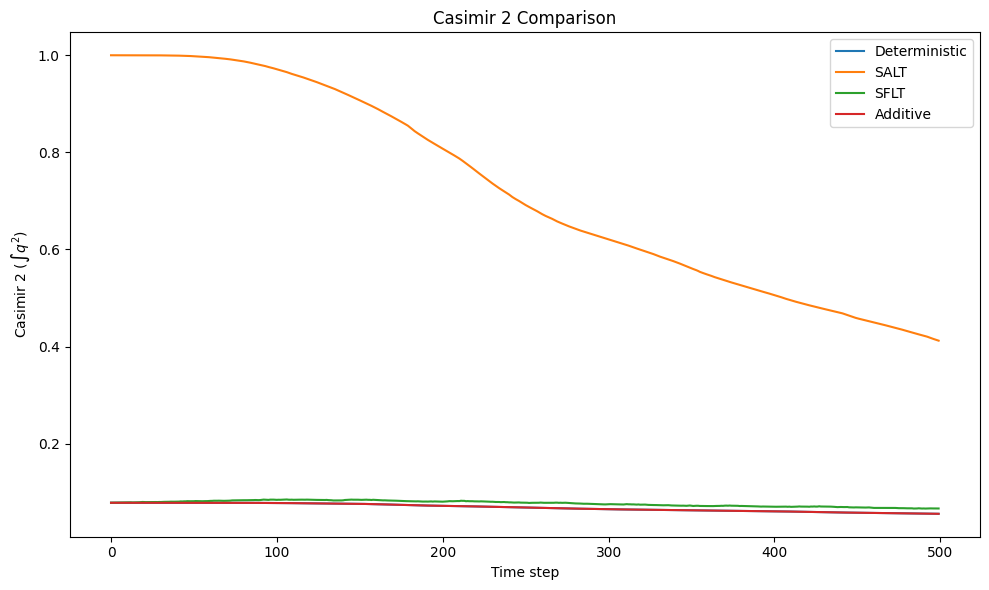

In [14]:

plt.figure(figsize=(10, 6))
plt.plot(energy_det, label='Deterministic')
plt.plot(energy_salt, label='SALT')
plt.plot(energy_sflt, label='SFLT')
plt.plot(energy_add, label='Additive')
plt.xlabel('Time step')
plt.ylabel('energy ($\int q$)')
plt.title('energy Comparison')
plt.legend()
plt.tight_layout()
plt.show()
# Casimir 1 comparison
plt.figure(figsize=(10, 6))
plt.plot(casimir1_det, label='Deterministic')
plt.plot(casimir1_salt, label='SALT')
plt.plot(casimir1_sflt, label='SFLT')
plt.plot(casimir1_add, label='Additive')
plt.xlabel('Time step')
plt.ylabel('Casimir 1 ($\int q$)')
plt.title('Casimir 1 Comparison')
plt.legend()
plt.tight_layout()
plt.show()

# Casimir 2 comparison
plt.figure(figsize=(10, 6))
plt.plot(casimir2_det, label='Deterministic')
plt.plot(casimir2_salt, label='SALT')
plt.plot(casimir2_sflt, label='SFLT')
plt.plot(casimir2_add, label='Additive')
plt.xlabel('Time step')
plt.ylabel('Casimir 2 ($\int q^2$)')
plt.title('Casimir 2 Comparison')
plt.legend()
plt.tight_layout()
plt.show()